<a href="https://githubtocolab.com/Astolfo2332/Biosenales_el_regreso/blob/main/Proyecto_3_los_4GB.ipynb"
    target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" /></a>

# Proyecto 3

4 GB de audio no es nada

## Descarga de Kaggel

Aqui mete el json de kaggle

In [ ]:
from google.colab import files

files.upload()


In [ ]:
!mkdir - p ~/.kaggle
!cp kaggle.json ~/.kaggle/
'chmod 600 /root/.kaggle/kaggle.json'  # Para proteger la información


In [ ]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database
! unzip respiratory-sound-database.zip


La mousque herramienta misteriosa

In [ ]:
!wget https://raw.githubusercontent.com/Astolfo2332/Biosenales_el_regreso/main/special_fun.py


# 1 El análisis

In [1]:
import os
import winsound
import special_fun as s
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as signal
import pywt
from scipy.signal import firwin
#Para que me avise
duration = 1000 
freq = 440 

## 1.1 Carga obtención de los audios

In [2]:
ruta_carpeta = './Data/audio_and_txt_files'
#Si es en colab
#ruta_carpeta = "/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files" 
lista_archivos = os.listdir(ruta_carpeta)
datos=s.sonido_probando123(lista_archivos,ruta_carpeta)

## Ejemplo del metodo usado

En este caso tomaremos un dato en particular para mostrar el proceso

In [3]:
y,sr=librosa.load(list(datos.keys())[20])

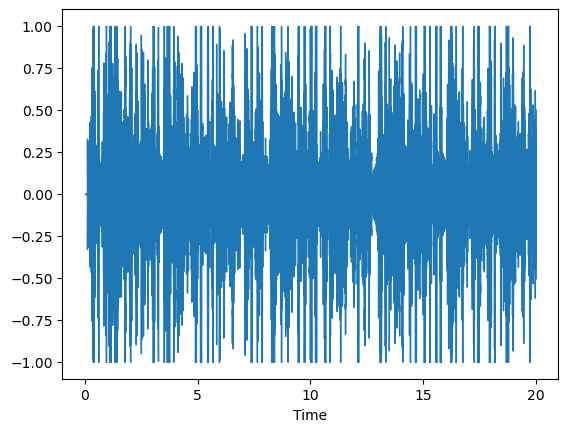

In [4]:
librosa.display.waveshow(y,sr=sr)

Creamos los filtros:

In [5]:
high=100
low=2000
nyq=sr/2
banda=(low-high)*0.1
orden=int(5*(nyq/banda))
if orden%2==0:
    orden+=1
low_pass=firwin(orden, low/nyq ,window=('kaiser',7.85))
high_pass=firwin(orden, high/nyq ,pass_zero="highpass",window=('kaiser',7.85))

Text(0.5, 1.0, 'Filtro pasa bajas')

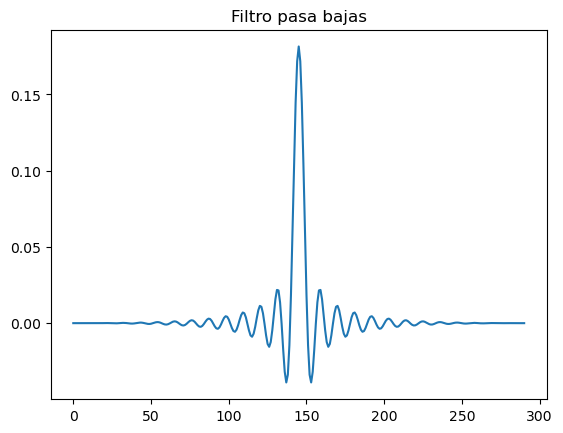

In [6]:
plt.plot(low_pass)
plt.title("Filtro pasa bajas")

Text(0.5, 1.0, 'Filtro pasa altas')

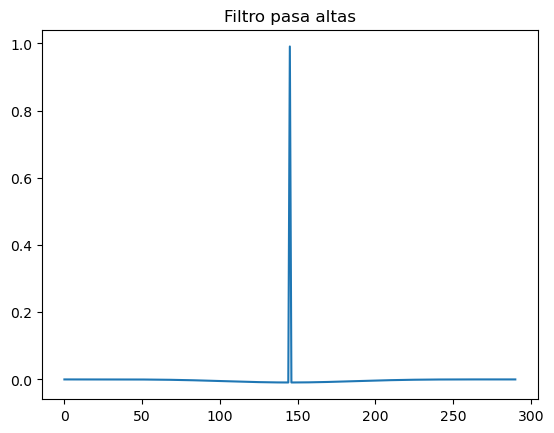

In [7]:
plt.plot(high_pass)
plt.title("Filtro pasa altas")

Text(0.5, 1.0, 'Señal después de filtro pasa altas')

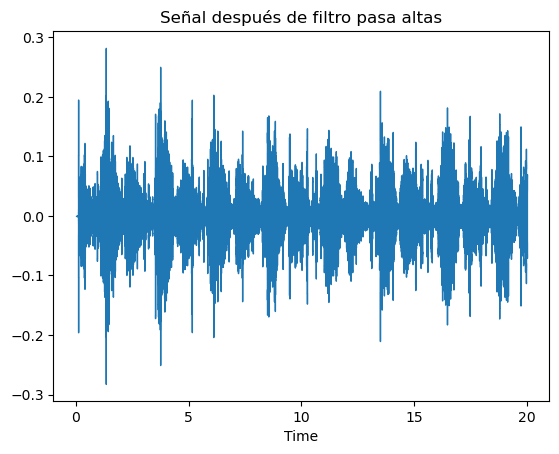

In [8]:
y_h = signal.filtfilt(high_pass, 1, y)
y_l = signal.filtfilt(low_pass, 1, y_h)
y = np.asfortranarray(y_l)
librosa.display.waveshow(y_h,sr=sr)
plt.title("Señal después de filtro pasa altas")

Text(0.5, 1.0, 'Señal después de ambos filtros aplicados')

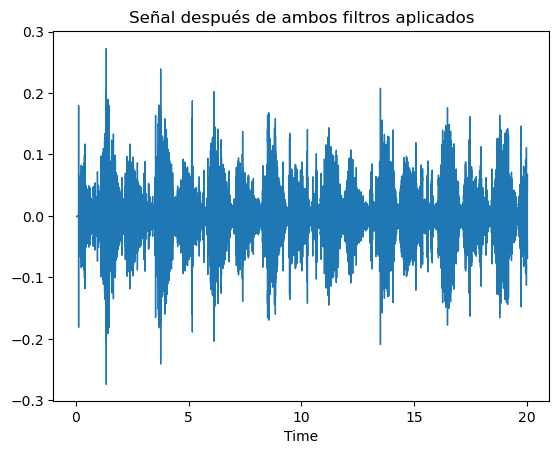

In [9]:
librosa.display.waveshow(y,sr=sr)
plt.title("Señal después de ambos filtros aplicados")

In [10]:
data_wavelet = pywt.wavedec( y, 'db6', level=8 )  
details = data_wavelet[1:]
details_t = s.wthresh(details)
rec=list()
rec.append(data_wavelet[0])
for i in range(len(details_t)): 
    rec.append(details_t[i]) 
x_rec = pywt.waverec( rec, 'db6') 
x_rec = x_rec[0:y.shape[0]]
y_fil=np.squeeze(y - x_rec)

La discriminación de los ciclos cardíacos

Text(0.5, 1.0, 'Discriminación ciclos cardíacos')

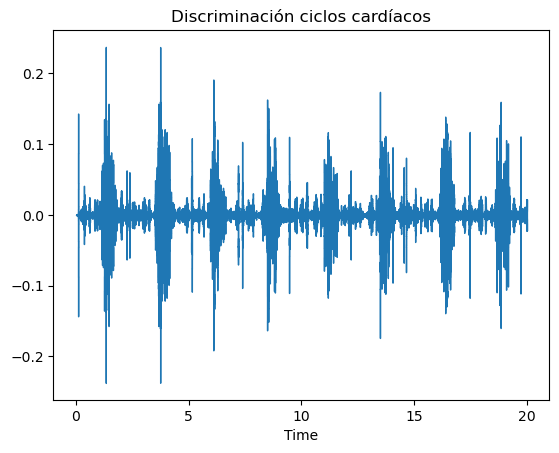

In [11]:
librosa.display.waveshow(x_rec,sr=sr)
plt.title("Discriminación ciclos cardíacos")

Text(0.5, 1.0, 'Señal filtrada')

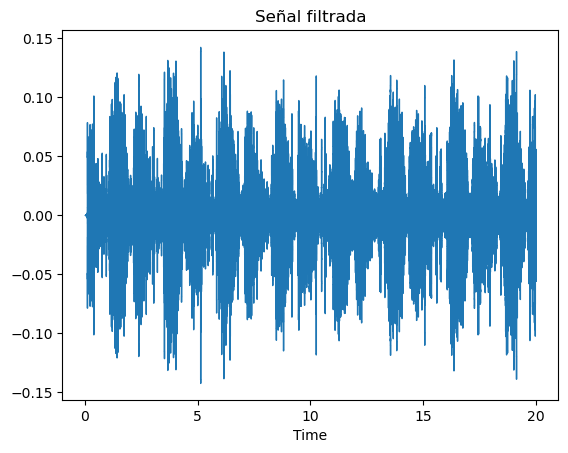

In [12]:
librosa.display.waveshow(y_fil,sr=sr)
plt.title("Señal filtrada")

Text(0, 0.5, 'Potencia')

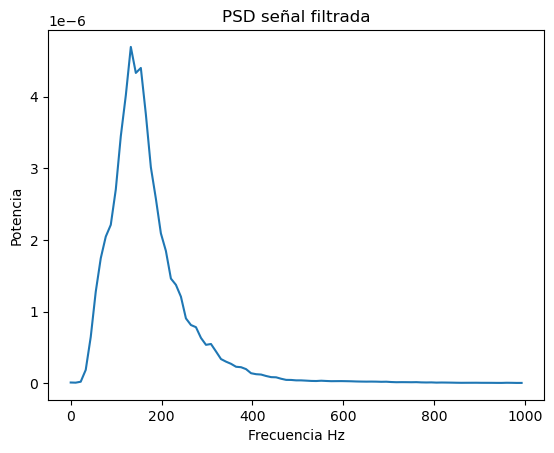

In [13]:
f,Pxx=signal.welch(y_fil,sr,"hamming",2000,1000,scaling="density")
r=f<1000
plt.plot(f[r],Pxx[r])
plt.title("PSD señal filtrada")
plt.xlabel("Frecuencia Hz")
plt.ylabel("Potencia")

# Generación de espectros

In [14]:
def custom_filter(fs,low=2000,high=100):
    nyq=fs/2
    banda=(low-high)*1.1
    orden=int(55*(nyq/banda))
    if orden%2==0:
        orden+=1
    low_pass=firwin(orden, low/nyq ,window=('kaiser',7.85),pass_zero="lowpass")
    high_pass=firwin(orden, high/nyq ,pass_zero="highpass",window=('kaiser',7.85))

    return low_pass,high_pass

In [15]:
low_pass,high_pass=custom_filter(datos[list(datos.keys())[0]][1])

In [16]:
def el_filtrador(data,low_pass,high_pass,nivel=10):
    y_h = signal.filtfilt(high_pass, 1, data)
    y_l = signal.filtfilt(low_pass, 1, y_h)
    y = np.asfortranarray(y_l)
    data_wavelet = pywt.wavedec( y, 'db6', level=nivel )  
    details = data_wavelet[1:]
    details_t = s.wthresh(details)
    rec=list()
    rec.append(data_wavelet[0])
    for i in range(len(details_t)): 
        rec.append(details_t[i]) 
    x_rec = pywt.waverec( rec, 'db6') 
    x_rec = x_rec[0:y.shape[0]]
    y_fil=np.squeeze(y - x_rec)
    return y_fil

In [17]:
def filtrar_todo(datos,low_pass,high_pass,level=10):
    fil={}
    for i in list(datos.keys()):
        y_fil=el_filtrador(datos[i][0],low_pass,high_pass,nivel=10)
        fil[i]=y_fil
    return fil

In [19]:
fil=filtrar_todo(datos,low_pass,high_pass,10)
winsound.Beep(freq, duration)

In [20]:
def welch_a(data,sr,rate):
    f,Pxx=signal.welch(data,sr,"hamming",rate[0],rate[1])
    return Pxx[f<1000]

In [21]:
def ciclos(datos,fil,fs,welchrate):
    sound_sanos=[]
    sound_crep=[]
    sound_sil=[]
    welch_sanos=[]
    welch_crep=[]
    welch_sil=[]
    los_wav=list(datos.keys())
    los_txt=[i.replace(".wav",".txt") for i in los_wav]
    for i in range(len(los_txt)):
        d=pd.read_csv(los_txt[i],sep="\t",header=None,names=["ini","end","crackles","wheezes"])
        for index,row in d.iterrows():
            paciente=los_wav[i]
            filti=fil[paciente]
            ini=int(row["ini"]*fs)
            fin=int(row["end"]*fs)
            ciclo=filti[ini:fin]
            if len(ciclo)>=40000:
                ciclo=ciclo[:40001]
                guelch=welch_a(ciclo,sr,welchrate)
                if int(row["wheezes"])==1:
                    sound_sil.append(ciclo)
                    welch_sil.append(guelch)
                if int(row["crackles"])==1:
                    sound_crep.append(ciclo)
                    welch_crep.append(guelch)
                if (int(row["wheezes"])==0) & (int(row["crackles"])==0):
                    sound_sanos.append(ciclo)
                    welch_sanos.append(guelch)
    return sound_sanos,sound_crep,sound_sil,welch_sanos,welch_crep,welch_sil


In [22]:
sound_sanos,sound_crep,sound_sil,welch_sanos,welch_crep,welch_sil=ciclos(datos,fil,sr,[2000,1000])

Text(0.5, 0, 'Frecuencia')

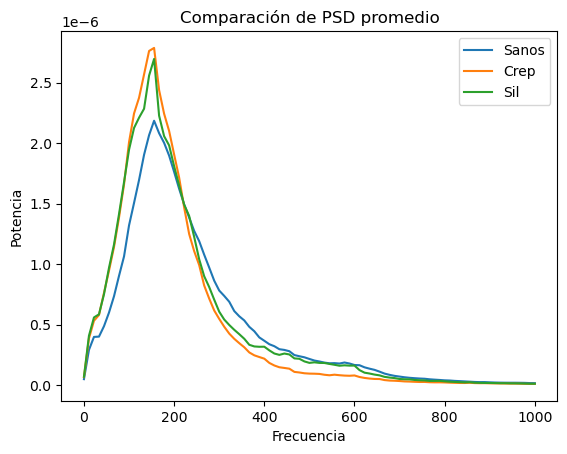

In [23]:
a=plt.figure()
prom=[welch_sanos,welch_crep,welch_sil]
new_prom=[]
f=np.linspace(0,1000,len(prom[0][0]))
for i in prom:
    new_prom.append(np.mean(i,axis=0))
for i in new_prom:
    plt.plot(f,i)
plt.title("Comparación de PSD promedio")
plt.legend(["Sanos","Crep","Sil"])
plt.ylabel("Potencia")
plt.xlabel("Frecuencia")



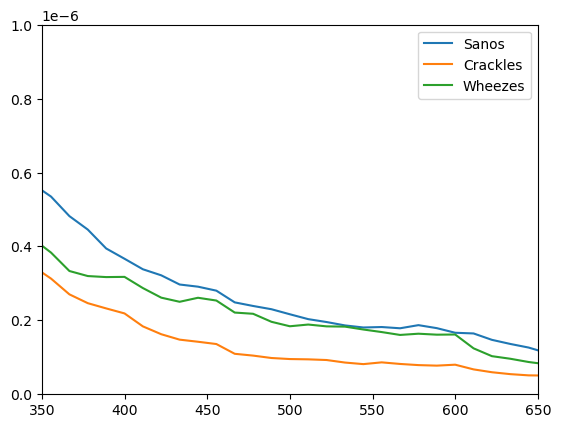

In [66]:
s.grafiquelo(new_prom,[350,650],[0,1e-6])

In [25]:
df=pd.DataFrame( np.array(new_prom))
df.to_csv("promedios.csv",index=False)

In [26]:
#!wget https://raw.githubusercontent.com/Astolfo2332/Biosenales_el_regreso/main/promedios.cvs

In [27]:
prom= np.loadtxt('promedios.csv', delimiter=',')
promedios=prom[1:]

## Rangos de comparación para la PSD

- Rango de los 3: 350 a 600 Hz


In [28]:
guelch=[welch_sanos,welch_crep,welch_sil]
listas=[sound_sanos,sound_crep,sound_sil]

In [29]:
def el_fraccionador(data,fmin=75,fmax=250):
    new_data=[]
    for paciente in data:
        new_ciclo=[]
        for ciclo in paciente:
                f=np.linspace(0,1000,len(ciclo))
                r=(fmax>f) & (fmin>f)
                new_ciclo.append(ciclo[r])
        new_data.append(new_ciclo)
    return new_data

In [30]:
def el_finalizador(data,data_sound,fmin=350,fmax=600):
    def sumatoria(data_frac):
            sum_datos.append(np.sum(data_frac))
    def mediana(data):
            mediana_datos.append(np.median(data))
    def varianza(sound_data,estado):
            var_datos.append(np.var(sound_data))
            fin_estado.append(estado)
    data_frac=el_fraccionador(data,fmin,fmax)
    estado=["Healthy","Crackles","Wheezes"]
    fin_estado=[]
    sum_datos=[]
    mediana_datos=[]
    var_datos=[]
    for i in range(len(estado)):
        status=estado[i]
        a_data=data[i]
        sound_data=data_sound[i]
        a_data_frac=data_frac[i]
        for ciclo in range(len(a_data)):
            sumatoria(a_data_frac[ciclo])
            mediana(a_data[ciclo])
            varianza(sound_data[ciclo],status)
    d={}
    d["Estado"]=fin_estado
    d["Sumatoria"]=sum_datos
    d["Mediana"]=mediana_datos
    d["Varianza"]=var_datos
    d=pd.DataFrame(d)
    return d

In [67]:
d=el_finalizador(guelch,listas,350,650)
d

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,3.243765e-07,7.324024e-10,0.000004
1,Healthy,2.857665e-07,4.143081e-10,0.000003
2,Healthy,2.532248e-07,3.037441e-10,0.000003
3,Healthy,2.838867e-07,2.288069e-10,0.000003
4,Healthy,2.605254e-07,3.094648e-10,0.000003
...,...,...,...,...
5850,Wheezes,5.515913e-06,1.626919e-08,0.000068
5851,Wheezes,5.544572e-06,1.081984e-08,0.000067
5852,Wheezes,7.781661e-07,7.846461e-10,0.000009
5853,Wheezes,7.326868e-07,5.946030e-10,0.000008


In [68]:
d.to_csv("Data_set_350_650.csv",index=False)

## Estadistica

In [33]:
#libreria para manejo de NDARRAY
import scipy as sp
#libreria para graficar
import matplotlib.pyplot as plt
#Lector de archivos csv
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols

import sympy as sym

from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import pingouin as pg


In [34]:
d3=pd.read_csv("Data_set_350_600.csv")

In [87]:
d3=d.copy()

# Los intentos fracasados de hacer algo bien en la vida por miguel:

In [108]:
def check_normality(data):

    pVals = pd.Series('p-value')
    # The scipy normaltest is based on D-Agostino and Pearsons test that
    # combines skew and kurtosis to produce an omnibus test of normality.

    _, pVals['Kolmogorov-Smirnov']   = stats.kstest((data-np.mean(data))/np.std(data,ddof=1), 'norm')
    
    return pVals['Kolmogorov-Smirnov'] 

In [109]:
def normality_table(data):
    names=data.columns.values
    sano={"Estado":["Healthy",'Kolmogorov-Smirnov']}
    psano=sum(data["Estado"]=="Healthy")
    pcrackles=sum(data["Estado"]=="Crackles")
    pwheezes=sum(data["Estado"]=="Wheezes")
    for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
        
        c=data.loc[0:psano-1,i]
        x=check_normality(c)
        if x>0.05:
            sano[i]=[True,x]
        else:
            sano[i]=[False,x]
    san=pd.DataFrame.from_dict(sano)
    cracles={"Estado":["Crackles",'Kolmogorov-Smirnov']}
    for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes parkinson

        c=data.loc[psano:pcrackles+psano-1,i]
        x=check_normality(c)
        if x>0.05:
            cracles[i]=[True,x]
        else:
            cracles[i]=[False,x]
    cra=pd.DataFrame.from_dict(cracles)
    wheezes={"Estado":["Wheezes",'Kolmogorov-Smirnov']}
    for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes parkinson

        c=data.loc[pcrackles+psano:pcrackles+psano+pwheezes,i]
        x=check_normality(c)
        if x>0.05:
            wheezes[i]=[True,x]
        else:
            wheezes[i]=[False,x]
    whe=pd.DataFrame.from_dict(wheezes)
    return pd.concat([san,cra,whe],ignore_index=True)

Box cox con lambas diferentes

In [110]:
d=d3.copy()
transformada1,lamda1=stats.boxcox(d3.loc[0:,['Sumatoria']].values.reshape(1,-1)[0])
transformada2,lamda2=stats.boxcox(d3.loc[0:,['Mediana']].values.reshape(1,-1)[0])
transformada3,lamda3=stats.boxcox(d3.loc[0:,['Varianza']].values.reshape(1,-1)[0])
d["Sumatoria"]=-transformada1
d['Mediana']=-transformada2
d['Varianza']=-transformada3
ns=normality_table(d)
ns

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,False,False,False
1,Kolmogorov-Smirnov,0.0,0.020012,0.0
2,Crackles,False,False,False
3,Kolmogorov-Smirnov,0.000067,0.009084,0.000069
4,Wheezes,False,True,False
5,Kolmogorov-Smirnov,0.00359,0.069136,0.003329


(array([  33.,  187.,  472.,  957., 1082., 1034., 1127.,  593.,  304.,
          66.]),
 array([1.69535457, 1.90416947, 2.11298438, 2.32179928, 2.53061418,
        2.73942908, 2.94824398, 3.15705889, 3.36587379, 3.57468869,
        3.78350359]),
 <BarContainer object of 10 artists>)

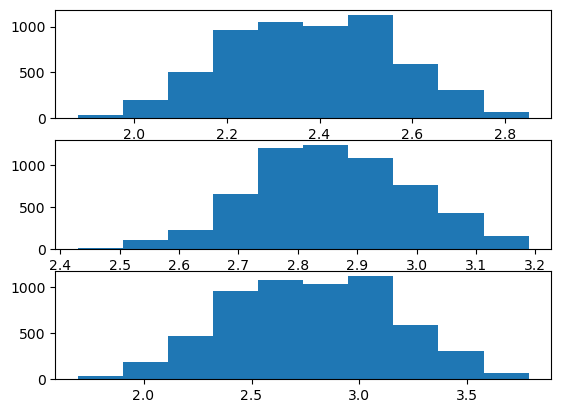

In [111]:
plt.subplot(3,1,1)
plt.hist(transformada1)
plt.subplot(3,1,2)
plt.hist(transformada2)
plt.subplot(3,1,3)
plt.hist(transformada3)

Haciendo un promedio

In [112]:
d=d3.copy()
lamda=np.mean(np.array([lamda1,lamda2,lamda3]))
transformada1=stats.boxcox(d3.loc[0:,['Sumatoria']].values.reshape(1,-1)[0],lmbda=lamda)
transformada2=stats.boxcox(d3.loc[0:,['Mediana']].values.reshape(1,-1)[0],lmbda=lamda)
transformada3=stats.boxcox(d3.loc[0:,['Varianza']].values.reshape(1,-1)[0],lmbda=lamda)
d["Sumatoria"]=-transformada1
d['Mediana']=-transformada2
d['Varianza']=-transformada3
ns=normality_table(d)
ns

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,False,False,False
1,Kolmogorov-Smirnov,0.0,0.028068,0.0
2,Crackles,False,False,False
3,Kolmogorov-Smirnov,0.000024,0.00641,0.000681
4,Wheezes,False,True,False
5,Kolmogorov-Smirnov,0.002057,0.075697,0.012625


(array([  27.,  146.,  397.,  809., 1156.,  923., 1219.,  721.,  382.,
          75.]),
 array([1.52172804, 1.67484442, 1.82796079, 1.98107717, 2.13419355,
        2.28730992, 2.4404263 , 2.59354268, 2.74665905, 2.89977543,
        3.05289181]),
 <BarContainer object of 10 artists>)

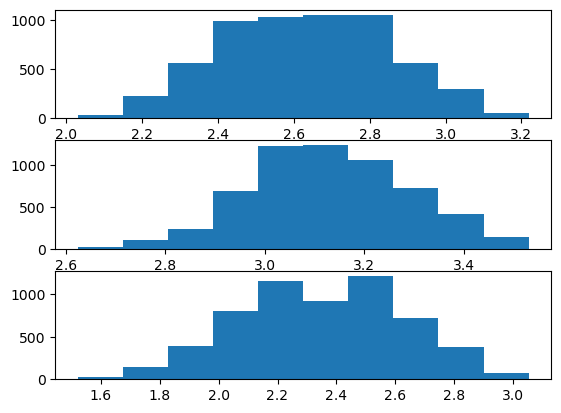

In [113]:
plt.subplot(3,1,1)
plt.hist(transformada1)
plt.subplot(3,1,2)
plt.hist(transformada2)
plt.subplot(3,1,3)
plt.hist(transformada3)

Inversa

In [114]:
d=d3.copy()
inv=1/d.loc[0:,['Sumatoria','Mediana','Varianza']].values
d3["Sumatoria"]=inv[:,0]
d3['Mediana']=inv[:,1]
d3['Varianza']=inv[:,2]
ns=normality_table(d)
ns

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,False,False,False
1,Kolmogorov-Smirnov,0.00001,0.00064,0.0
2,Crackles,False,False,False
3,Kolmogorov-Smirnov,0.0,0.000001,0.0
4,Wheezes,False,False,False
5,Kolmogorov-Smirnov,0.000002,0.015791,0.000001


Log

In [115]:
d=d3.copy()
log=np.log(d.loc[0:,['Sumatoria','Mediana','Varianza']].values)
d["Sumatoria"]=log[:,0]
d['Mediana']=log[:,1]
d['Varianza']=log[:,2]
ns=normality_table(d)
ns

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,False,False,False
1,Kolmogorov-Smirnov,0.0,0.021469,0.0
2,Crackles,False,False,False
3,Kolmogorov-Smirnov,0.000047,0.008665,0.001505
4,Wheezes,False,True,False
5,Kolmogorov-Smirnov,0.002979,0.069993,0.0132


Log10

In [116]:
d=d3.copy()
log10=np.log10(d.loc[0:,['Sumatoria','Mediana','Varianza']].values)
d["Sumatoria"]=log10[:,0]
d['Mediana']=log10[:,1]
d['Varianza']=log10[:,2]
ns=normality_table(d)
ns

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,False,False,False
1,Kolmogorov-Smirnov,0.0,0.021469,0.0
2,Crackles,False,False,False
3,Kolmogorov-Smirnov,0.000047,0.008665,0.001505
4,Wheezes,False,True,False
5,Kolmogorov-Smirnov,0.002979,0.069993,0.0132


Log2

In [117]:
d=d3.copy()
log2=np.log2(d.loc[0:,['Sumatoria','Mediana','Varianza']].values)
d3["Sumatoria"]=log2[:,0]
d3['Mediana']=log2[:,1]
d3['Varianza']=log2[:,2]
ns=normality_table(d)
ns

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,False,False,False
1,Kolmogorov-Smirnov,0.0,0.0,0.0
2,Crackles,False,True,False
3,Kolmogorov-Smirnov,0.014021,0.538162,0.00073
4,Wheezes,False,False,False
5,Kolmogorov-Smirnov,0.000082,0.021936,0.000002


sqrt

In [118]:
d=d3.copy()
sqrt=np.sqrt(d.loc[0:,['Sumatoria','Mediana','Varianza']].values)
d["Sumatoria"]=sqrt[:,0]
d['Mediana']=sqrt[:,1]
d['Varianza']=sqrt[:,2]
ns=normality_table(d)
ns

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,False,False,False
1,Kolmogorov-Smirnov,0.0,0.0,0.0
2,Crackles,False,True,False
3,Kolmogorov-Smirnov,0.014021,0.538162,0.00073
4,Wheezes,False,False,False
5,Kolmogorov-Smirnov,0.000082,0.021936,0.000002


In [119]:
def caja_bigotes2(data1,data2,data3,var):

    # Crear una lista de nombres para las etiquetas del gráfico
    labels = ['Healthy', 'Crackles','Wheezes']

    plt.boxplot([data1[var], data2[var], data3[var]], labels=labels)
    plt.title(var)
    plt.show()

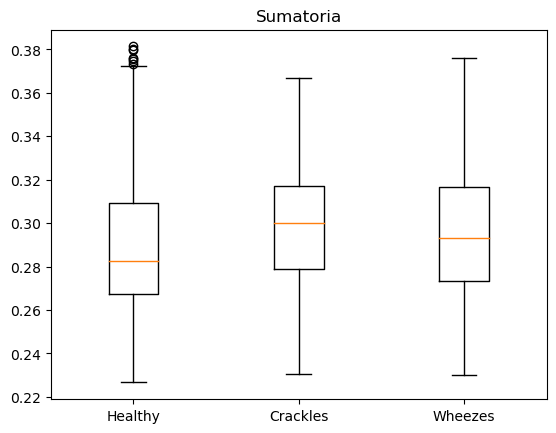

In [120]:
sano,crakles,wheezes = [d3[d3['Estado']=='Healthy'], d3[d3['Estado']=='Crackles'],d3[d3['Estado']=='Wheezes']]
caja_bigotes2(sano,crakles,wheezes,'Sumatoria')

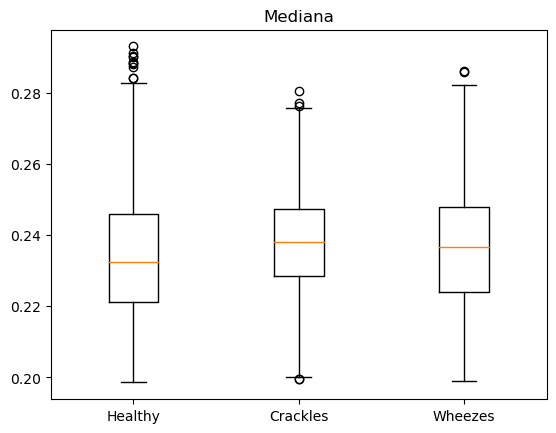

In [121]:
caja_bigotes2(sano,crakles,wheezes,'Mediana')

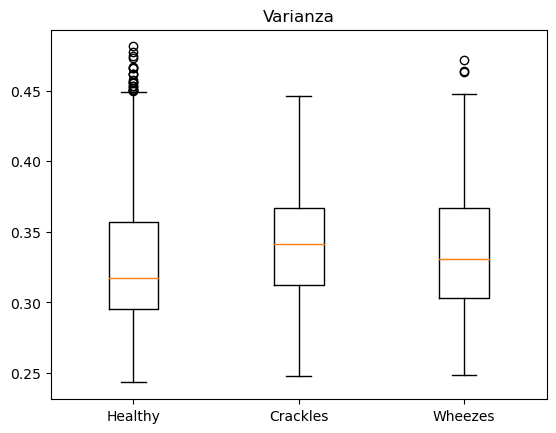

In [122]:
caja_bigotes2(sano,crakles,wheezes,'Varianza')

In [123]:
ns=normality_table(d3)
ns

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,False,False,False
1,Kolmogorov-Smirnov,0.0,0.000134,0.0
2,Crackles,False,True,False
3,Kolmogorov-Smirnov,0.012677,0.104409,0.042796
4,Wheezes,False,False,False
5,Kolmogorov-Smirnov,0.001684,0.036178,0.00069


In [124]:
def prueba_u(data):
    sano,crakles,wheezes = [data[data['Estado']=='Healthy'], data[data['Estado']=='Crackles'],data[data['Estado']=='Wheezes']]
    names=data.columns.values
    namest=names[1:]
 
    stat1, p1 = mannwhitneyu(sano[namest],crakles[namest])
    stat2, p2 = mannwhitneyu(sano[namest],wheezes[namest])

    con=0
    for i in p1: 
        print('Statistics=%.3f, p=%.3f for channel %s' % (stat1[con], i,namest[con]))
        con+=1
        #interpret
        alpha = 0.05
        if i > alpha:
            print('Same distribution (fail to reject H0)')
        else:
            print('Different distribution (reject H0)')
    con=0
    for i in p2: 
        print('Statistics=%.3f, p=%.3f for channel %s' % (stat2[con], i,namest[con]))
        con+=1
        #interpret
        alpha = 0.05
        if i > alpha:
            print('Same distribution (fail to reject H0)')
        else:
            print('Different distribution (reject H0)')

In [125]:
prueba_u(d3)

Statistics=2144754.000, p=0.000 for channel Sumatoria
Different distribution (reject H0)
Statistics=2353729.000, p=0.000 for channel Mediana
Different distribution (reject H0)
Statistics=2190736.000, p=0.000 for channel Varianza
Different distribution (reject H0)
Statistics=1269107.000, p=0.000 for channel Sumatoria
Different distribution (reject H0)
Statistics=1346264.000, p=0.000 for channel Mediana
Different distribution (reject H0)
Statistics=1283211.000, p=0.000 for channel Varianza
Different distribution (reject H0)


In [126]:
def grafhist(data):
    con=1
    try:
        names=data.columns
        plt.figure()
        plt.suptitle("Distribución de datos de "+data[names[0]][0])
        for i in names[1:]:
            plt.subplot(3,1,con)
            plt.hist(data[i],bins=100)
            plt.axvline(data[i].mean(),color="r",linestyle="dashed",linewidth=2)
            plt.title(i)
            con+=1
    except KeyError:
        print('error')

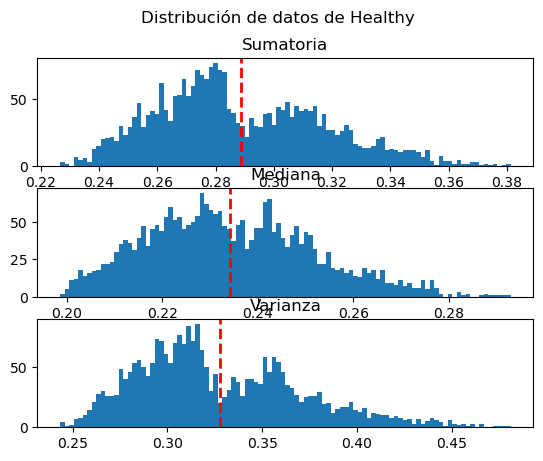

In [127]:
grafhist(sano)